# ts_aos_analysis

# AOS  DM-46763:  WET-007 Compare CWFS approaches with OR4 ComCam data 

For https://rubinobs.atlassian.net/browse/SITCOM-1149

Last verified to run 2024/10/22

Versions:

* lsst_distrib w_2024_37 (ext, cvmfs)

* ts_wep v11.5.2

Use AOS OR4 LsstComCamSim  data. It is in `embargo_or4` repository. The planner for observations was https://github.com/jmeyers314/aos_block_planner/blob/main/OR4.ipynb  

In this notebook we run ISR, donut detection and cutouts, and TIE / Danish Zernike retrieval. Given that this was a simulation the OPD files are available to compare against.  The main objective is to verify whether TIE / Danish provide similar fit results (and whether they match the OPD expectation).



## Imports

In [26]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
import numpy as np

## Inspect the data

First, find out the range of data for the first OR4 night:

In [24]:
butler = dafButler.Butler('embargo_or4')
len(list(butler.registry.queryDatasets('raw', collections=['LSSTComCamSim/defaults'],
                                        where= "instrument='LSSTComCamSim' and day_obs=20240625").expanded()))

7758

Check how in this particular simulation the `observation_type` connects to `seq_num`: 

In [25]:
dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTComCamSim/defaults'],
                                         where= "day_obs=20240625 and instrument='LSSTComCamSim'").expanded()

for ref in list(dataRefs)[:150]:
    print(ref.dataId.exposure.id, ref.dataId.exposure.observation_type, ref.dataId.exposure.seq_num,
         ref.dataId.exposure.observation_reason, ref.dataId.exposure.science_program)
    

7024062500001 bias 1 bias unknown
7024062500002 bias 2 bias unknown
7024062500003 bias 3 bias unknown
7024062500004 bias 4 bias unknown
7024062500005 bias 5 bias unknown
7024062500006 bias 6 bias unknown
7024062500007 bias 7 bias unknown
7024062500008 bias 8 bias unknown
7024062500009 bias 9 bias unknown
7024062500010 bias 10 bias unknown
7024062500011 bias 11 bias unknown
7024062500012 dark 12 dark unknown
7024062500013 dark 13 dark unknown
7024062500014 dark 14 dark unknown
7024062500015 dark 15 dark unknown
7024062500016 dark 16 dark unknown
7024062500017 dark 17 dark unknown
7024062500018 dark 18 dark unknown
7024062500019 dark 19 dark unknown
7024062500020 dark 20 dark unknown
7024062500021 dark 21 dark unknown
7024062500022 dark 22 dark unknown
7024062500023 flat 23 flat unknown
7024062500024 flat 24 flat unknown
7024062500025 flat 25 flat unknown
7024062500026 flat 26 flat unknown
7024062500027 flat 27 flat unknown
7024062500028 flat 28 flat unknown
7024062500029 flat 29 flat un

How many datasets have `observation_type` of `cwfs`:

In [4]:
len(list(butler.registry.queryDatasets('raw', collections=['LSSTComCamSim/defaults'],
         where= "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'").expanded()))


414

Run these through ISR pipeline:

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007

    
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:developers
    

    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i LSSTComCamSim/defaults \
    -o u/scichris/or4_night1_isr \
    -p lsstComCamSimPipelineISR.yaml \
    -d "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"


The summary report:  `/sdf/data/rubin/shared/scichris/DM-46763_WET-007/submit/u/scichris/or4_night1_isr/20241018T003228Z`:


                 UNKNOWN MISFIT UNREADY READY PENDING RUNNING DELETED HELD SUCCEEDED FAILED PRUNED EXPECTED
    ------------ ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    TOTAL              0      0       0     0       1       0       0    0       415      0      0      416
    ------------ ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    pipetaskInit       0      0       0     0       0       0       0    0         1      0      0        1
    isr                0      0       0     0       0       0       0    0       414      0      0      414
    finalJob           0      0       0     0       1       0       0    0         0      0      0        1


Check the ISR results:

In [5]:
butler = dafButler.Butler('embargo_or4')
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=['u/scichris/or4_night1_isr']).expanded()
refs = []
for ref in dataRefs: 
    refs.append(ref)
print(len(refs))

414


That shows that indeed all the `raw` datasets now are avaiable as `postISRCCD`. Show a postISR exposure:

In [8]:
refs[0].dataId.exposure.id

7024062500100

Text(0.5, 0, 'y [px]')

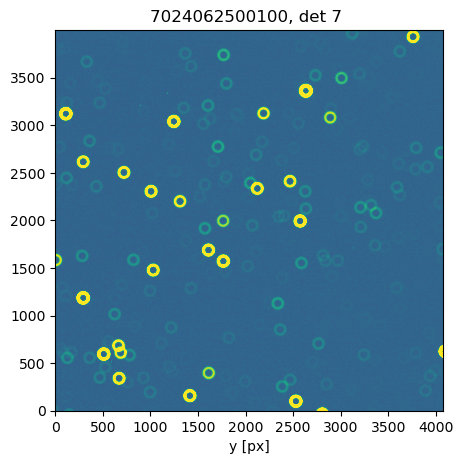

In [9]:
exp = butler.get('postISRCCD', dataId=refs[0].dataId, collections=['u/scichris/or4_night1_isr'])
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(5,5))
idx=0

d = exp.image.array
vmin,vmax = zscale.get_limits(d)
ax.imshow(d, vmin=vmin, vmax=vmax, origin='lower')

detId = refs[idx].dataId.detector.id
ax.set_title(f'{refs[0].dataId.exposure.id}, det {detId} ')
ax.set_xlabel('x [px]')
ax.set_xlabel('y [px]')

Run donut detection and cutouts with `bps` 



    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i u/scichris/or4_night1_isr \
    -o u/scichris/or4_night1_direct_stamps \
    -p lsstComCamSimPipelineDirectCutoutOnly.yaml \
    -d " exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"
    
The summary report:


                                  UNKNOWN MISFIT UNREADY READY PENDING RUNNING DELETED HELD SUCCEEDED FAILED PRUNED EXPECTED
    ----------------------------- ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    TOTAL                               0      0       0     0       0       0       0    0       425      0      0      425
    ----------------------------- ------- ------ ------- ----- ------- ------- ------- ---- --------- ------ ------ --------
    pipetaskInit                        0      0       0     0       0       0       0    0         1      0      0        1
    generateDonutDirectDetectTask       0      0       0     0       0       0       0    0       414      0      0      414
    cutOutDonutsScienceSensorTask       0      0       0     0       0       0       0    0         9      0      0        9
    finalJob                            0      0       0     0       0       0       0    0         1      0      0        1


Check that the donut cutouts make sense: 

In [499]:
butler = dafButler.Butler('embargo_or4')
dataRefs = butler.registry.queryDatasets('donutStampsIntra', 
           collections=['u/scichris/or4_night1_direct_stamps'],
                                        where=f"instrument='LSSTComCamSim'").expanded()
for ref in list(dataRefs)[:20]:
    print(ref)

donutStampsIntra@{instrument: 'LSSTComCamSim', detector: 1, visit: 7024062500128, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=StampsBase] (run=u/scichris/or4_night1_direct_stamps/20241018T020526Z id=dfe26383-b181-4324-b0dd-e37343b3a6d8)
donutStampsIntra@{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062500071, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=StampsBase] (run=u/scichris/or4_night1_direct_stamps/20241018T020526Z id=2751a363-8e1f-4916-b842-a82a8d9b178a)
donutStampsIntra@{instrument: 'LSSTComCamSim', detector: 6, visit: 7024062500068, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=StampsBase] (run=u/scichris/or4_night1_direct_stamps/20241018T020526Z id=29dd8339-eff9-4ed3-9eba-c8fd859549af)
donutStampsIntra@{instrument: 'LSSTComCamSim', detector: 6, visit: 7024062500062, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=StampsBase] (run=u/scichris/or4_night1_direct_stamps/20241018T020526Z id=43c58798-e22e-4a28-83ff-36a079

In [26]:
donutStampsIntra = butler.get('donutStampsIntra', dataId=ref.dataId,
                              collections=['u/scichris/or4_night1_direct_stamps'])

In [500]:
len(donutStampsIntra)

40

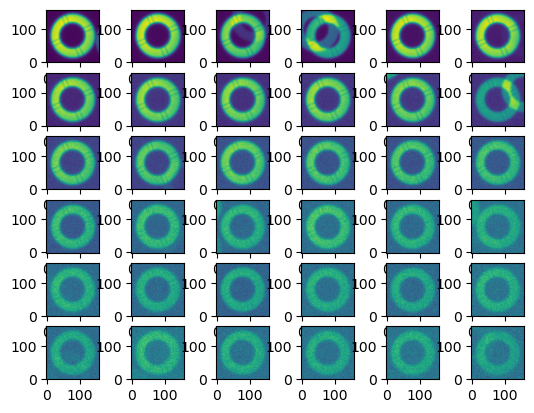

In [31]:
import numpy as np 
fig,axs = plt.subplots(6,6)

ax = np.ravel(axs)

for i  in range(len(ax)):
    stamp = donutStampsIntra[i]
    ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
if len(donutStampsIntra)<len(ax):
    for i in range(len(donutStampsIntra), len(ax)):
        ax[i].axis('off')
        

There are a lot of donuts as we used `donutSelector.useCustomMagLimit: True` to provide as many donuts as possible.

Now we can run the Danish and TIE; the pipelines contain

    # This yaml file is used to define the tasks and configuration of
    # a Gen 3 pipeline used for testing
    description: basic processing pipeline with imsim
    
    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstComCamSim
    
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
           python: |
              from lsst.ts.wep.task import EstimateZernikesTieTask, EstimateZernikesDanishTask
              config.estimateZernikes.retarget(EstimateZernikesDanishTask)
      aggregateZernikesTask: lsst.donut.viz.AggregateZernikesTask
      aggregateDonutCatalogsTask: lsst.donut.viz.AggregateDonutCatalogsTask
      aggregateAOSVisitTableTask: lsst.donut.viz.AggregateAOSVisitTableTask
      plotAOSTask: lsst.donut.viz.PlotAOSTask
      aggregateDonutStampsTask: lsst.donut.viz.AggregateDonutStampsTask
      plotDonutTask: lsst.donut.viz.PlotDonutTask
    
    
(`config.estimateZernikes.retarget(EstimateZernikesTieTask)`  for the TIE version )

    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q roma -g 1800 s3df --account rubin:developers
    
    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i u/scichris/or4_night1_direct_stamps \
    -o u/scichris/or4_night1_direct_danish \
    -p lsstComCamSimPipelineCalcDanish.yaml \
    -d " exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"
     
    bps report --id 3284025.0
    
     
    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i u/scichris/or4_night1_direct_stamps \
    -o u/scichris/or4_night1_direct_tie \
    -p lsstComCamSimPipelineCalcTie.yaml  \
    -d " exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"
    
    bps report --id 3284027.0

Check the outputs:  

In [10]:
butler = dafButler.Butler('embargo_or4')

# find a query that returns all the donuts
len(list(butler.registry.queryDimensionRecords(
    "exposure", 
    where="day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'",
)))

46

In [11]:
print(len(list(butler.registry.queryDatasets(
    "postISRCCD", 
    where="day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'",
    collections=['u/scichris/or4_night1_direct_stamps']
).expanded())))

414


In [501]:
for dr in butler.registry.queryDatasets("zernikeEstimateAvg", collections="u/scichris/or4_night1_direct_danish").expanded():
    print(dr)
    break

zernikeEstimateAvg@{instrument: 'LSSTComCamSim', detector: 3, visit: 7024062500119, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=NumpyArray] (run=u/scichris/or4_night1_direct_danish/20241018T040540Z id=f975fe5d-047b-4a10-94e0-81799775af3f)


In [502]:
butler.getURI(dr)

ResourcePath("s3://embargo@rubin-summit-users/u/scichris/or4_night1_direct_danish/20241018T040540Z/zernikeEstimateAvg/20240625/i/i_06/7024062500119/zernikeEstimateAvg_LSSTComCamSim_i_i_06_7024062500119_R22_S10_u_scichris_or4_night1_direct_danish_20241018T040540Z.pickle")

In [503]:
# Try to find data with zernike Pyramid
list(butler.registry.queryDatasets("residualZernikePyramid", collections="u/scichris/or4_night1_direct_danish"))[:10]

[]

Why are there no datasets created by the aggregate tasks?  Try running them interactively, only the aggregation step:




    REPO=embargo_or4
    INPUT_COLLECTION=u/scichris/or4_night1_direct_danish
    OUTPUT_COLLECTION=u/scichris/or4_night1_direct_danish_viz
    PIPELINE_FILE=/sdf/group/rubin/shared/scichris/DM-46763_WET-007/donut_pipeline.yaml
    
    cat <<EOF > $PIPELINE_FILE
    description: Donut pipeline
    instrument: lsst.obs.lsst.LsstComCamSim
    tasks:
      aggregateZernikesTask: lsst.donut.viz.AggregateZernikesTask
      aggregateDonutCatalogsTask: lsst.donut.viz.AggregateDonutCatalogsTask
      aggregateAOSVisitTableTask: lsst.donut.viz.AggregateAOSVisitTableTask
      plotAOSTask: lsst.donut.viz.PlotAOSTask
      aggregateDonutStampsTask: lsst.donut.viz.AggregateDonutStampsTask
      plotDonutTask: lsst.donut.viz.PlotDonutTask
    EOF
    
    pipetask run -j 9 -b $REPO -i $INPUT_COLLECTION -o $OUTPUT_COLLECTION -p $PIPELINE_FILE -d "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'" --register-dataset-types



Check the output collection:

In [66]:
butler =  dafButler.Butler('embargo_or4')
dr = butler.registry.queryDatasets('donutPlot*', collections=['u/scichris/or4_night1_direct_danish_viz'],
                                  where="instrument='LSSTComCamSim' and visit=7024062500074").expanded()
refs = []
for ref in dr:
    print(ref)
    refs.append(ref)

donutPlotExtra@{instrument: 'LSSTComCamSim', visit: 7024062500074, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=Plot] (run=u/scichris/or4_night1_direct_danish/20241018T040540Z id=016b7b6d-695f-4894-9899-180170720c6e)
donutPlotExtra@{instrument: 'LSSTComCamSim', visit: 7024062500074, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=Plot] (run=u/scichris/or4_night1_direct_danish_viz/20241018T045049Z id=967b50aa-4880-4d42-8a9a-e2faddb24bce)
donutPlotIntra@{instrument: 'LSSTComCamSim', visit: 7024062500074, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=Plot] (run=u/scichris/or4_night1_direct_danish/20241018T040540Z id=291bfc72-e48d-4e02-8fb6-9815deacc8c7)
donutPlotIntra@{instrument: 'LSSTComCamSim', visit: 7024062500074, band: 'i', day_obs: 20240625, physical_filter: 'i_06'} [sc=Plot] (run=u/scichris/or4_night1_direct_danish_viz/20241018T045049Z id=e363e9fe-34fd-4672-b1aa-2d87ff334344)


Both `donutPlotExtra` , `donutPlotIntra` are there:

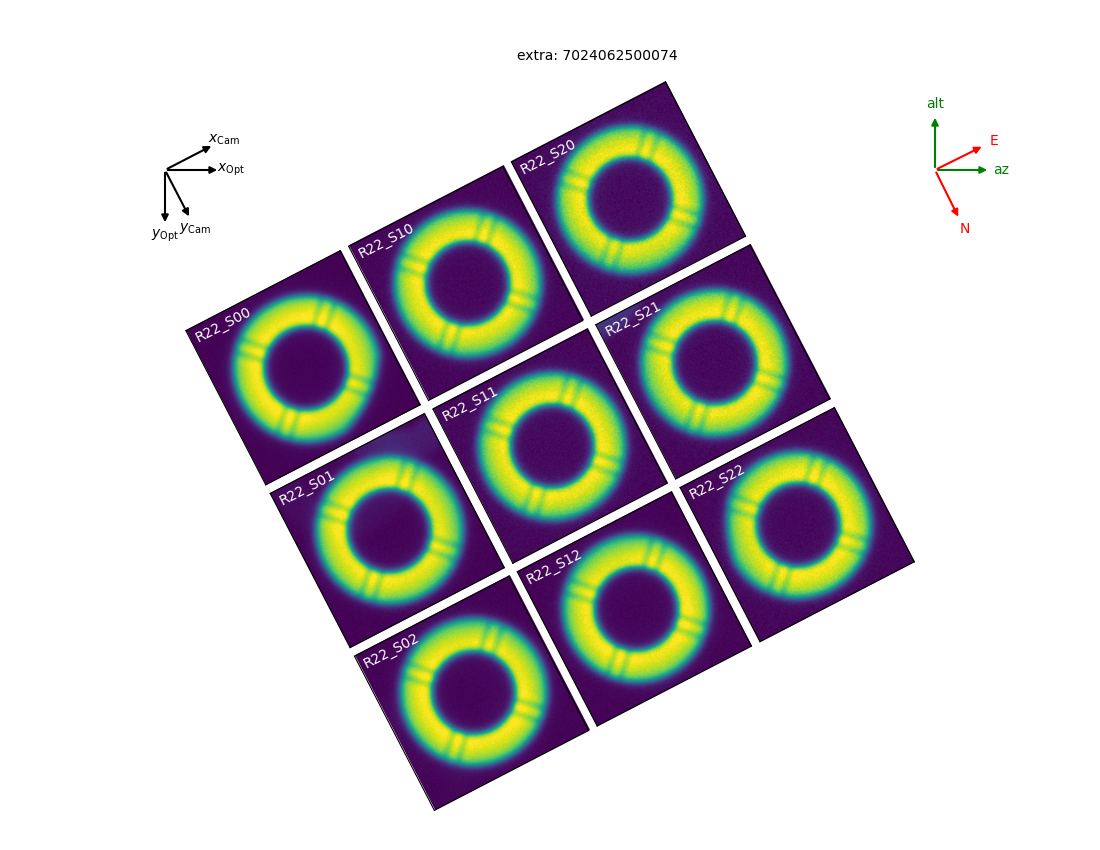

In [69]:
from IPython.display import Image
butler.getURI(refs[1])
Image(butler.getURI(refs[1]).read())

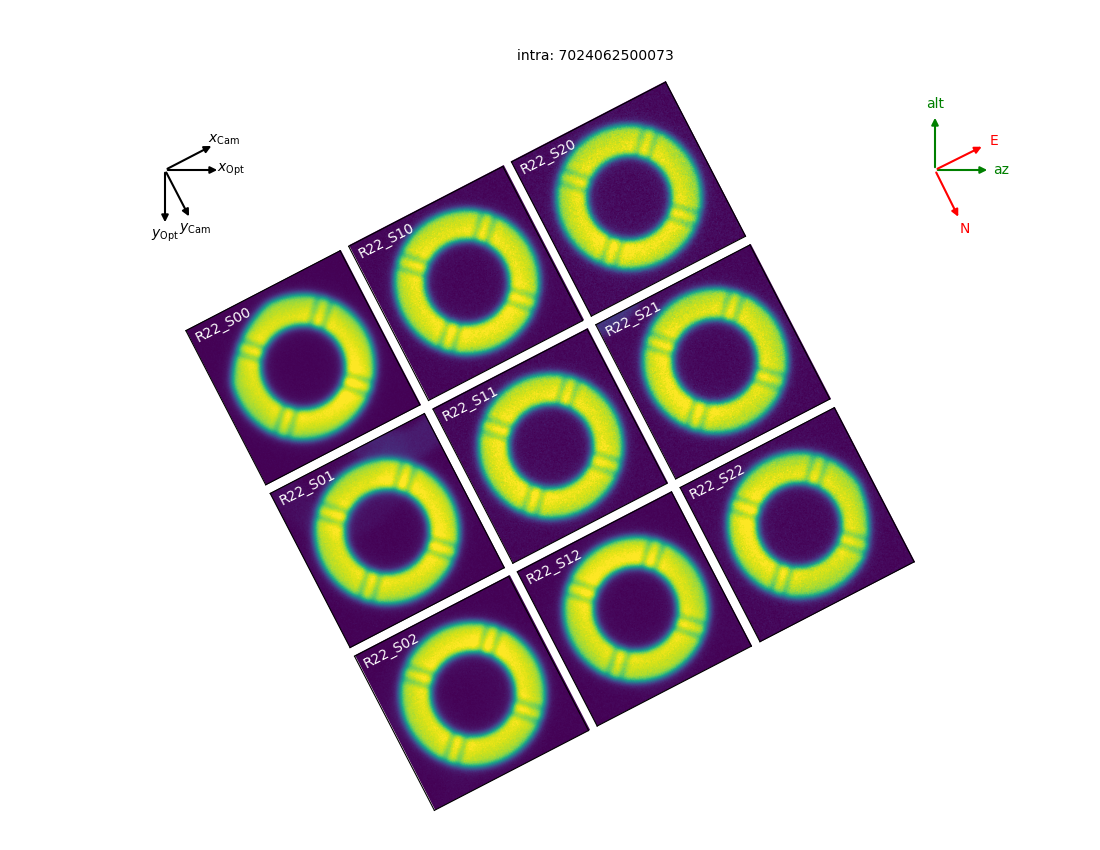

In [70]:
butler.getURI(refs[2])
Image(butler.getURI(refs[2]).read())

But no `residualZernikePyramid` :

In [79]:
list(butler.registry.queryDatasets('residual*', collections=['u/scichris/or4_night1_direct_danish_viz'])

[]

## Compare Danish and TIE fit results:

In [12]:
butler = dafButler.Butler('embargo_or4')
collection = 'u/scichris/or4_night1_direct_danish'

dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw',collections=[collection]).expanded()


In [13]:
butler = dafButler.Butler('embargo_or4')
dataRefsMethod={}
for method in ['tie', 'danish']:
    collection = f'u/scichris/or4_night1_direct_{method}'
    dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw',collections=[collection]).expanded()
    dataRefsMethod[method]=dataRefs

In [14]:
len(list(dataRefsMethod['tie']))

207

In [15]:
len(list(dataRefsMethod['danish']))

207

In [16]:
list(dataRefsMethod['tie'])[0]

DatasetRef(DatasetType('zernikeEstimateRaw', {band, instrument, day_obs, detector, physical_filter, visit}, NumpyArray), {instrument: 'LSSTComCamSim', detector: 7, visit: 7024062500083, band: 'i', day_obs: 20240625, physical_filter: 'i_06'}, run='u/scichris/or4_night1_direct_tie/20241018T040647Z', id=4f512c25-7154-4bcc-a871-a55e90a27190)

Store the information about each dataRef in a table:

In [28]:
from astropy.table import Table

detId=[]; detName=[]; visits=[]; day=[]; refId=[]; seqNum=[]
refs=[]
i=0

butler = dafButler.Butler('embargo_or4')
collection = 'u/scichris/or4_night1_direct_danish'
dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw',collections=[collection]).expanded()

for ref in dataRefs:
    #refs.append(ref)
    detId.append(ref.dataId.detector.id)
    detName.append(ref.dataId.detector.full_name)
    visits.append(ref.dataId.visit.id)
    day.append(ref.dataId.day_obs.id)
    refId.append(i)
    seqNum.append(ref.dataId.visit.seq_num)
    i+=1 

table = Table(data=[detId, detName, visits, day,refId,seqNum], names=['detId', 'detName', 'visit', 'day','refId','seqNum'])

Load all results to a dictionary for quicker plotting:

In [29]:
# prepare  the dictionary
results = {}
for method in ['danish','tie']:
    results[method] = {}
    for visit in np.unique(visits):
        results[method][visit] = {}
        
# let's see if the refs from one collection work for the other given that they have the same content 
for ref in dataRefs:
    detector = ref.dataId.detector.id
    visit = ref.dataId.visit.id
    for method in results.keys():
        collection = f'u/scichris/or4_night1_direct_{method}'
        results[method][visit][detector] = {'zernikeEstimateAvg':
                                            butler.get('zernikeEstimateAvg', dataId=ref.dataId, collections=[collection]
                                                      ),
                                            'zernikeEstimateRaw':
                                            butler.get('zernikeEstimateRaw', dataId=ref.dataId, collections=[collection]
                                                      ),
                                            'dataId': ref.dataId
                                           }

Plot OPD for three sequential seq_nums, showing which OPD is in-focus (the one with small Z1, which is defocus) : 

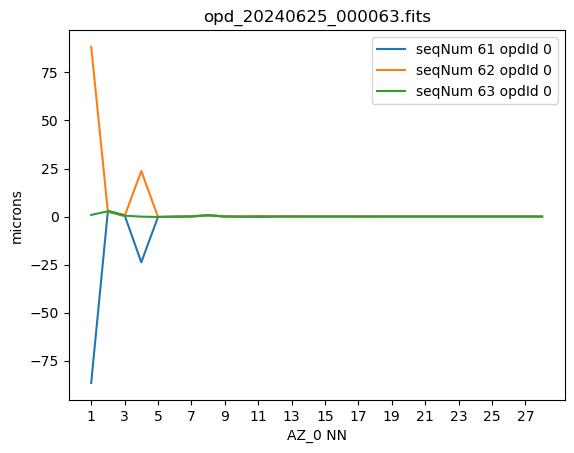

In [30]:
from astropy.io import fits
fpath = '/sdf/data/rubin/repo/aos_imsim/raw/OR4/output/'
day_obs = str(visit)[2:8]
seq_num = int(str(visit)[-3:])

opds = {}
for seqs in range(61,64):# , seq_num+1, seq_num+2]:
    
    opd_fname = f'opd_20{day_obs}_0000{seqs}.fits'
    #det_name = det_num_to_name[det_num]
    #truth_fname = f'truth_CC_S_20{day_obs}_000{seq_num}-0-i-{det_name}-00{det_num}.txt.gz'
    opd = fits.open(os.path.join(fpath, opd_fname))
    #truth =  Table.read(os.path.join(fpath, truth_fname),format='ascii' )
    
    opd_dic_1_28 = {}
    for idx in range(9):
        opd_dic_1_28[idx]=[]
        for key in opd[idx].header.keys():
            if key.startswith('AZ'):
              opd_dic_1_28[idx].append(opd[idx].header[key])
    opds[seqs] = opd_dic_1_28

for seqs in opds.keys():
    opd_dic = opds[seqs]
    #for idx in range(9):
    plt.plot(np.arange(1,29),  np.array(opd_dic[0][:])/1000., label=f'seqNum {seqs} opdId {0}')
plt.ylabel('microns')
plt.xticks(range(1,29,2))
plt.xlabel('AZ_0 NN')
plt.title(opd_fname)
plt.legend()



Each intra/extra pair is thus followed by an in-focus exposure: 

    7024062500059 focus 59
    7024062500060 focus 60
    7024062500061 cwfs 61 : intra 
    7024062500062 cwfs 62 : extra 
    7024062500063 acq 63 : in-focus 
    7024062500064 cwfs 64
    7024062500065 cwfs 65
    7024062500066 acq 66
    7024062500067 cwfs 67
    7024062500068 cwfs 68
    7024062500069 acq 69
    ...

The first in each sequence is intra-focal, extra-focal, then in-focus.  All Zernikes are calculated based on intra/extra pair, and stored under the extra-focal seqNum (eg. 62). Thus showing Zk fit for seqNum 62, used  seqNum 61 and 62 to make, and the corresponding in-focus OPD has seqNum 63.   

Show that the OPD locations were indeed the middle of each detector, and that the detector_id matches that of the OPD. The main difference is that the OPD is in CCS, which is the transpose of DVCS  i.e. `THX`, `THY` is transpose of the `FIELD_X`, `FIELD_Y`.  

In [31]:
from astropy.io import fits
fpath = '/sdf/data/rubin/repo/aos_imsim/raw/OR4/output/'
day_obs = str(visit)[2:8]
seq_num = str(visit)[-3:]
opd_fname = f'opd_20{day_obs}_000{seq_num}.fits'
#det_name = det_num_to_name[det_num]
#truth_fname = f'truth_CC_S_20{day_obs}_000{seq_num}-0-i-{det_name}-00{det_num}.txt.gz'
opd = fits.open(os.path.join(fpath, opd_fname))
#truth =  Table.read(os.path.join(fpath, truth_fname),format='ascii' )

opd_dic_1_28 = {}
for idx in range(9):
    opd_dic_1_28[idx]=[]
    for key in opd[idx].header.keys():
        if key.startswith('AZ'):
          opd_dic_1_28[idx].append(opd[idx].header[key])

In [32]:
from lsst.obs.lsst import LsstComCamSim
from lsst.afw.cameraGeom import PIXELS, FIELD_ANGLE, FOCAL_PLANE
camera = LsstComCamSim.getCamera()

detIds = []
detNames = []
detXp = []
detYp = []
for i in range(9):
    det = camera.get(i)
    xp_rad, yp_rad = det.getCenter(FIELD_ANGLE)  # in radians 
    xp_deg =  np.rad2deg(xp_rad)
    yp_deg = np.rad2deg(yp_rad)
    print(det.getName(), det.getId(), xp_deg, yp_deg)
    detIds.append(det.getId())
    detNames.append(det.getName())
    detXp.append(xp_deg)
    detYp.append(yp_deg)

R22_S00 0 -0.23506922430603078 -0.23506922430603067
R22_S01 1 -5.5615177023204074e-05 -0.2350297381000236
R22_S02 2 0.23495793774546245 -0.23506918676901617
R22_S10 3 -0.23502973810002364 -5.56151770231843e-05
R22_S11 4 -5.5605919144620414e-05 -5.560591914460066e-05
R22_S12 5 0.23491847056951398 -5.5615168221938267e-05
R22_S20 6 -0.23506918676901623 0.2349579377454625
R22_S21 7 -5.561516822195803e-05 0.23491847056951404
R22_S22 8 0.23495790022653712 0.23495790022653712


Text(0, 0.5, 'FIELD Y / THX [deg]')

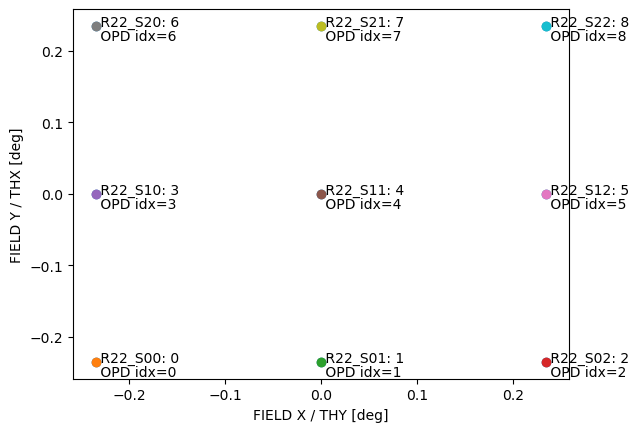

In [33]:
plt.scatter(detXp, detYp)
for i in range(9):
    plt.text(detXp[i], detYp[i], f' {detNames[i]}: {detIds[i]}')
    
    plt.scatter( opd[i].header['THY'], opd[i].header['THX'],)
    plt.text(opd[i].header['THY'] , opd[i].header['THX'] -0.02, f' OPD idx={i}')
    
plt.xlabel('FIELD X / THY [deg]')
plt.ylabel('FIELD Y / THX [deg]')          

This shows that if we correct for the fact that the  OPD is in CCS, and detector in DVCS, the actual order (`detId` and `opdId`) is the same. 

We can identify visits that went into zernike estimation by considering which donuts were used for the estimation. We take cutouts from two visit , and manually run Zk estimation to compare to that obtained with pipetask run that used a batch submission constrained by a data query

    "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"

Take the dataId for one method, one detector:

In [453]:
results[method][7024062500062][4]['dataId']

{instrument: 'LSSTComCamSim', detector: 4, visit: 7024062500062, band: 'i', day_obs: 20240625, physical_filter: 'i_06'}

Read in the donuts from the first cutout: 

In [34]:
butler = dafButler.Butler('embargo_or4')
collection = 'u/scichris/or4_night1_direct_danish'
donutStampsExtra = butler.get('donutStampsExtra', dataId=results[method][7024062500062][4]['dataId'],  collections=[collection])
donutStampsIntra = butler.get('donutStampsIntra', dataId=results[method][7024062500062][4]['dataId'],  collections=[collection])

In [35]:
donutStampsIntra.metadata.getArray('VISIT')[0]

7024062500061

In [36]:
donutStampsExtra.metadata.getArray('VISIT')[0]

7024062500062

Run interactive estimation and compare to the pipetask run:

In [460]:
from lsst.ts.wep.task.calcZernikesTask import ( CalcZernikesTask, CalcZernikesTaskConfig )
from lsst.ts.wep.task import EstimateZernikesTieTask
from lsst.ts.wep.task import EstimateZernikesDanishTask

config = CalcZernikesTaskConfig()
config.estimateZernikes.retarget(EstimateZernikesTieTask)
#config.estimateZernikes.retarget(EstimateZernikesDanishTask)
task = CalcZernikesTask(config=config)
taskOut = task.run( donutStampsExtra, donutStampsIntra)

INFO:CombineZernikesSigmaClipTask:MaxZernClip config: 3. MaxZernClip used: 3.
INFO:CombineZernikesSigmaClipTask:Using 25 pairs out of 34 in final Zernike estimate.


In [464]:
taskOut.outputZernikesAvg

array([[ 1.64021967e+00,  9.86008792e-03, -2.42377371e-02,
         1.99158413e-02, -9.38833128e-03, -8.78355914e-03,
         1.38989462e-02,  7.01217579e-02,  3.65613643e-03,
        -3.64882918e-03, -8.35202770e-04,  1.25672859e-03,
         2.85679977e-03, -3.32459278e-03, -2.78493271e-03,
        -1.44823024e-03, -5.19714029e-03, -7.60281738e-04,
         7.56978202e-03,  8.90640699e-04, -1.67056089e-03,
         1.47638435e-04, -1.64017655e-03,  4.69028415e-03,
        -5.65732269e-03]])

In [465]:
results[method][7024062500062][4]['zernikeEstimateAvg']

array([[ 1.64021967e+00,  9.86008792e-03, -2.42377371e-02,
         1.99158413e-02, -9.38833128e-03, -8.78355914e-03,
         1.38989462e-02,  7.01217579e-02,  3.65613643e-03,
        -3.64882918e-03, -8.35202770e-04,  1.25672859e-03,
         2.85679977e-03, -3.32459278e-03, -2.78493271e-03,
        -1.44823024e-03, -5.19714029e-03, -7.60281738e-04,
         7.56978202e-03,  8.90640699e-04, -1.67056089e-03,
         1.47638435e-04, -1.64017655e-03,  4.69028415e-03,
        -5.65732269e-03]])

The two are identical, which proves that exactly these donuts were used for that dataRef. 

Plot the two methods for all detectors from a single visit: 

Plot OPD together with the TIE  / Danish estimate:

In [37]:
visit = 7024062500062
day_obs = str(visit)[2:8]
seq_num_opd = int(str(visit)[-3:])+1
opd_fname = f'opd_20{day_obs}_0000{seq_num_opd}.fits'
opd = fits.open(os.path.join(fpath, opd_fname))

opd_dic_1_28 = {}
for idx in range(9):
    opd_dic_1_28[idx]=[]
    for key in opd[idx].header.keys():
        if key.startswith('AZ'):
          opd_dic_1_28[idx].append(opd[idx].header[key])

Text(0.05, 0.5, 'Zk value [microns]')

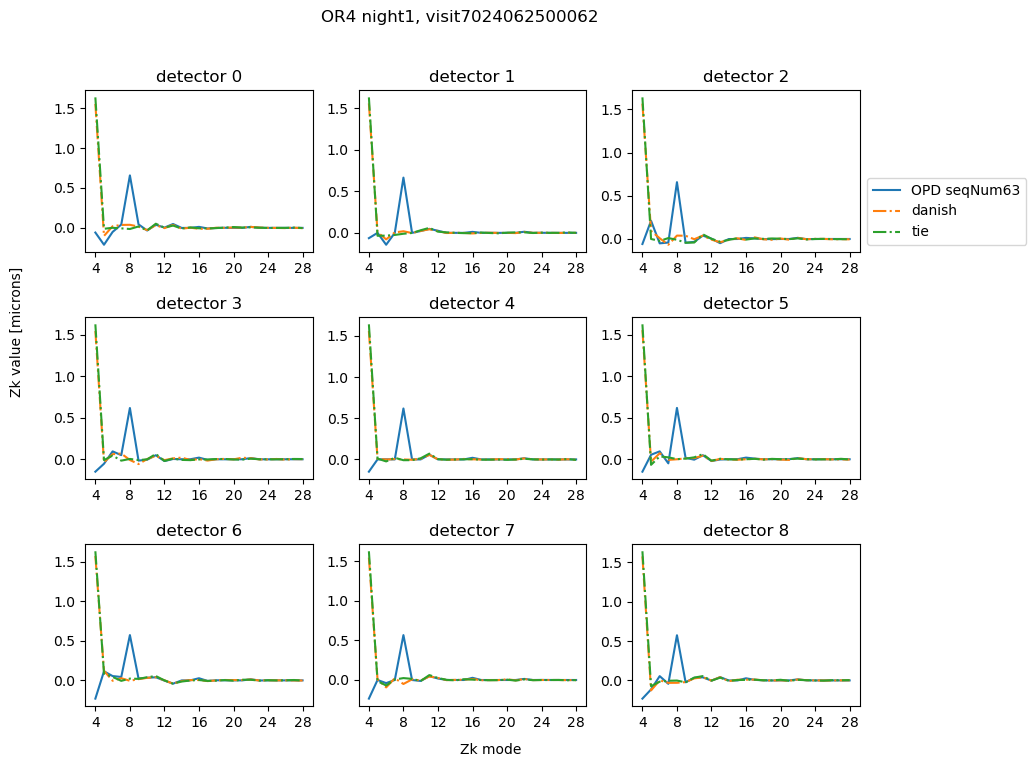

In [38]:
fig,axs = plt.subplots(3,3,figsize=(10,8))
ax = np.ravel(axs)
for i in range(len(ax)):
    opd_idx = i #  order of OPD  is the same as that of detectors det_idx_to_opd[i]
    opd_microns_4_28 = np.array(opd_dic_1_28[opd_idx][3:])/1000
    ax[i].plot(np.arange(4,29), opd_microns_4_28, ls='-', label=f'OPD seqNum{seq_num_opd}')
    for method in results.keys():    
        
        ax[i].plot(np.arange(4,29),results[method][visit][i]['zernikeEstimateAvg'][0], ls='-.', label=method)
        ax[i].set_title(f'detector {i}')
        ax[i].set_xticks(range(4,29,4))
    #ax[i].set_ylim(-0.1,0.5)
ax[2].legend(bbox_to_anchor=[1.0,0.5])
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f'OR4 night1, visit{visit}')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')

Plot other OPD seqNums just in case:

In [39]:
visit = 7024062500062
day_obs = str(visit)[2:8]


opds = {}
for seqs in range(60,66):# , seq_num+1, seq_num+2]:
    
    opd_fname = f'opd_20{day_obs}_0000{seqs}.fits'
    opd = fits.open(os.path.join(fpath, opd_fname))
    opd_dic_1_28 = {}
    for idx in range(9):
        opd_dic_1_28[idx]=[]
        for key in opd[idx].header.keys():
            if key.startswith('AZ'):
              opd_dic_1_28[idx].append(opd[idx].header[key])
    opds[seqs]=opd_dic_1_28
                

In [46]:
for seq_num in opds.keys():
    print(seq_num, opds[seq_num][i][0])

60 1031.7986384837156
61 -86591.91986693893
62 88286.31211660568
63 840.1687263632309
64 -86771.9358891346
65 88106.35051679649


Plot only OPDs for in-focus exposures in that range:

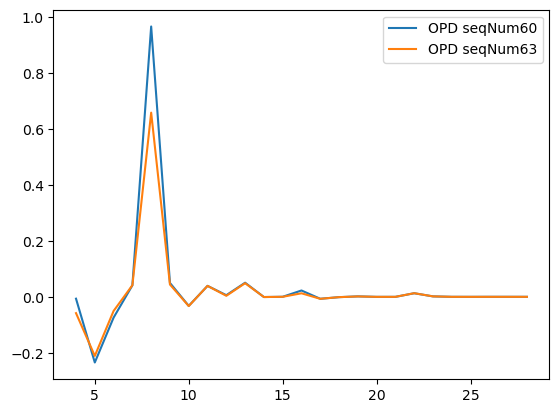

In [48]:
i=0
fig,ax = plt.subplots(1,1)
for seq_num in opds.keys():
    if abs(opds[seq_num][i][0])<10000:
        opd_microns_4_28 = np.array(opds[seq_num][i][3:])/1000
        ax.plot(np.arange(4,29), opd_microns_4_28, ls='-', label=f'OPD seqNum{seq_num}')
ax.legend()

In [ ]:
This shows that selecting a different OPD doesn't really bring it closer to TIE/Danish fit. 

Text(0.05, 0.5, 'Zk value [microns]')

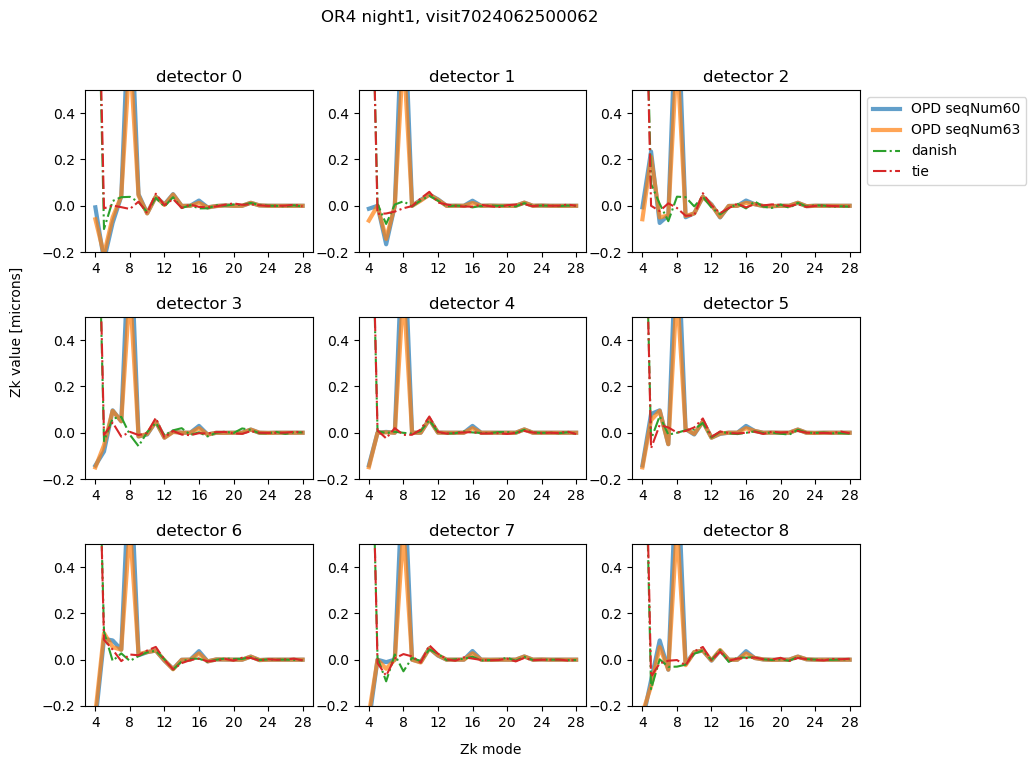

In [54]:
fig,axs = plt.subplots(3,3,figsize=(10,8))
ax = np.ravel(axs)
for i in range(len(ax)):
    for seq_num in [60,63]:
        opd_microns_4_28 = np.array(opds[seq_num][i][3:])/1000
        ax[i].plot(np.arange(4,29), opd_microns_4_28, ls='-', lw=3, alpha=0.7, label=f'OPD seqNum{seq_num}')
    for method in results.keys():    
        ax[i].plot(np.arange(4,29),results[method][visit][i]['zernikeEstimateAvg'][0], ls='-.', label=method)
        ax[i].set_title(f'detector {i}')
        ax[i].set_xticks(range(4,29,4))
    ax[i].set_ylim(-0.2,0.5)
ax[2].legend(loc="upper left", bbox_to_anchor=[1.0,1.], )
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f'OR4 night1, visit{visit}')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')

The main discrepancy is Z8 (horizontal coma) and Z4 (defocus)

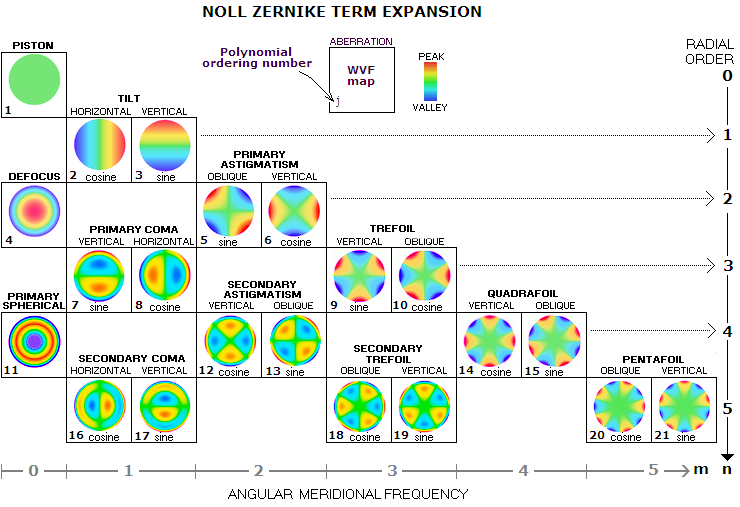

Show whether there is much difference between TIE and Danish for all defocal pairs:

In [59]:
min(visits)

7024062500062

Text(0.05, 0.5, '$\\Delta$ zk fit (Danish-TIE) [microns]')

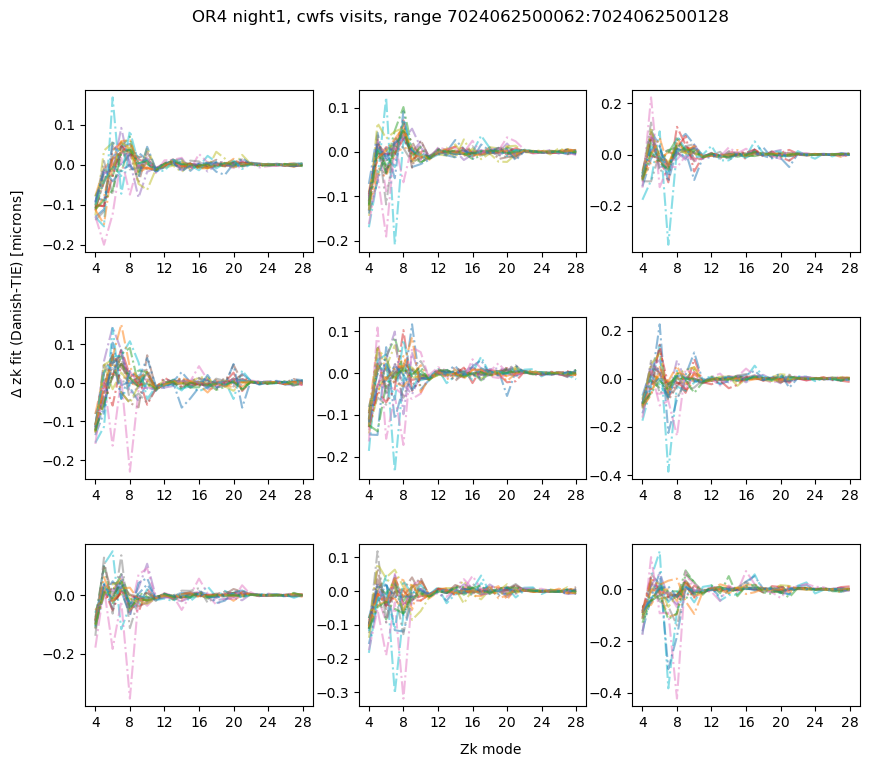

In [60]:
fig,axs = plt.subplots(3,3,figsize=(10,8))
ax = np.ravel(axs)
for i in range(len(ax)):
    
    for visit in results['danish'].keys():
        danishFit = results['danish'][visit][i]['zernikeEstimateAvg'][0] 
        tieFit = results['tie'][visit][i]['zernikeEstimateAvg'][0] 
        diff = danishFit-tieFit   
        ax[i].plot(np.arange(4,29), diff, ls='-.', alpha=0.5, label=visit)
    ax[i].set_xticks(range(4,29,4))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f'OR4 night1, cwfs visits, range {min(visits)}:{max(visits)}')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5, f'$\Delta$ zk fit (Danish-TIE) [microns]', rotation='vertical')

If we plot that as absolute difference, we'll notice that most of the exposures have agreement within 0.1 microns: